In [2]:
import random
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score


### Fonction pour calculer le temps d'exécution du chiffrage, déchiffrage à partir d'une clé, d'un message et du nombre d'itérations ###

def single_test(key, msg, cipher_time, decipher_time, nb_iterations_single):
    
    # Calcul des temps dans la boucle
    
    cipher_time_loop = []
    decipher_time_loop = []
    
    for iterations in range(nb_iterations_single):
        
        # Start first timer
        
        cipher_start = time.perf_counter()
    
        cipher = AES.new(key, AES.MODE_CFB)
        encrypted_msg = cipher.encrypt(msg)    
        iv = cipher.iv
    
        # End first timer
    
        cipher_end = time.perf_counter()
    
        cipher_time_loop.append(cipher_end-cipher_start)
    
        # Start second timer
    
        decipher_start = time.perf_counter()
        
        decipher = AES.new(key, AES.MODE_CFB, iv=iv)
        decrypted_msg = decipher.decrypt(encrypted_msg) 

        # End second timer
    
        decipher_end = time.perf_counter()

        decipher_time_loop.append(decipher_end-decipher_start)

    # On ajoute la moyenne des temps
    
    cipher_time.append(np.mean(cipher_time_loop))
    decipher_time.append(np.mean(decipher_time_loop))

    
    
    
    
### Fonction pour comparer le temps d'exécution entre AES-128 et AES-256 sur une taille de message correspondant à une puissance de 10 ###
    
def test_msg(exposant, nb_iterations, nb_iterations_single):
    
    # Initialisation des clés
    
    key_128 = get_random_bytes(16)
    key_256 = get_random_bytes(32)

    # Initialisation des KPIs
    
    cipher_time_128 = []
    decipher_time_128 = []

    cipher_time_256 = []
    decipher_time_256 = []
    
    # Pour le nombre d'itérations souhaité
    
    for i in range(nb_iterations):
        msg = get_random_bytes(pow(10,exposant))
        single_test(key_128, msg, cipher_time_128, decipher_time_128, nb_iterations_single)
        single_test(key_256, msg, cipher_time_256, decipher_time_256, nb_iterations_single)
    
    print("AES 128 : Temps écoulé total : ", sum(cipher_time_128)+sum(decipher_time_128))
    print("AES 128 : Temps de chiffrement moyen : ", sum(cipher_time_128)/len(cipher_time_128))
    print("AES 128 : Temps de déchiffrement moyen : ", sum(decipher_time_128)/len(decipher_time_128))
    print("\n\n")
    print("AES 256 : Temps écoulé total : ", sum(cipher_time_256)+sum(decipher_time_256))
    print("AES 256 : Temps de chiffrement moyen : ", sum(cipher_time_256)/len(cipher_time_256))
    print("AES 256 : Temps de déchiffrement moyen : ", sum(decipher_time_256)/len(decipher_time_256))
    print("\n\n")
    print("L'AES 256 est "+str(round(100*(sum(cipher_time_256)+sum(decipher_time_256)-(sum(cipher_time_128)+sum(decipher_time_128)))/(sum(cipher_time_128)+sum(decipher_time_128)),2))+"(%) fois plus long")
    

In [3]:
### Fonction pour comparer AES-128 et AES-256 de manière précise réparti sur les facteurs de 128, en fonction du pas et du nombre d'itérations souhaité ###
### Elle affiche et sauvegarde des graphiques de comparaison dont celui d'une régression linéaire ###

def compare_aes_precise(facteur_inf , facteur_sup, step, nb_iterations, nb_iterations_single):
    
    # Initialisation des clés
    
    key_128 = get_random_bytes(16)
    key_256 = get_random_bytes(32)
    
    # Initialisation des KPI pour les deux AES
    
    mean_128 = []
    mean_256 = []
    
    # Initialisation de la taille des messages
    
    X = np.arange(facteur_inf, facteur_sup, step)*128
    
    # Initialisation des KPIs
    
    cipher_time_128 = []
    decipher_time_128 = []

    cipher_time_256 = []
    decipher_time_256 = []
               
    for points in X:
        
     # Nombre d'itérations sur la taille du message
        
        for i in range(nb_iterations):
                
            msg = get_random_bytes(int(points))
            
            single_test(key_256, msg, cipher_time_256, decipher_time_256, nb_iterations_single)
            single_test(key_128, msg, cipher_time_128, decipher_time_128, nb_iterations_single)
        
        # Puis on calcule la moyenne pour le point actuel
        
        mean_128.append(np.mean(np.add(cipher_time_128, decipher_time_128)))
        mean_256.append(np.mean(np.add(cipher_time_256, decipher_time_256)))
            
    # Reshape de la data pour la régression linéaire
    
    X = X.reshape(-1, 1)
    
    # Font pour le style
    
    font1 = {'family':'serif','color':'blue','size':20}
    font2 = {'family':'serif','color':'darkred','size':15}
    
# Légende et paramètrages du temps d'exécution
    
    plt.title("Temps d'exécution pour %i itérations" % (nb_iterations*nb_iterations_single), fontdict = font1)
    plt.xlabel("Taille du message (en octets)", fontdict = font2)
    plt.ylabel("Temps d'exécution moyen (en s)", fontdict = font2)
    
    # Affichage des valeurs 
    
    plt.scatter(X,mean_256, label="AES-256", s=1)
    plt.scatter(X,mean_128, label="AES-128", s=1)
    plt.legend(loc="upper left")
    
    # Sauvegarde et affichage
        
    plt.savefig("img/Temps d'exécution pour %i itérations" % (nb_iterations*nb_iterations_single), transparent=True)
    plt.show()
    
# Création de la différence en %
    
    percent=[]
    
    for i in range(len(mean_128)):
        percent.append(round(100*((mean_256[i]-mean_128[i])/mean_128[i]),2))
    
    # Légende et paramètrages
    
    plt.title("Différence pour %i itérations" % (nb_iterations*nb_iterations_single), fontdict = font1)
    plt.xlabel("Taille du message (en octets)", fontdict = font2)
    plt.ylabel("Différence (en %)", fontdict = font2)
        
    # Plot des valeurs
    
    plt.scatter(X, percent, s=1)
    
    # Sauvegarde et affichage
    
    plt.savefig("img/Différence du temps d'exécution pour %i itérations" % (nb_iterations*nb_iterations_single), transparent=True)
    plt.show()
    
    
# Régression linéaire 
    
    reg256 = linear_model.LinearRegression()
    reg256.fit(X, mean_256)
    
    reg128 = linear_model.LinearRegression()
    reg128.fit(X, mean_128)
    
    # Prédiction de la régression linéaire
    
    mean_256_predict = reg256.predict(X)
    mean_128_predict = reg128.predict(X)
    
    # Légende et paramètrages
    
    plt.title("Régression linéaire", fontdict = font1)
    plt.xlabel("Taille du message (en octets)", fontdict = font2)
    plt.ylabel("Temps d'exécution (en s)", fontdict = font2)
    
    # Plot des valeurs 
    
    plt.plot(X, mean_256_predict, label="AES-256 pred")
    plt.plot(X, mean_128_predict, label="AES-128 pred")
    plt.legend(loc="upper left")
    
    # Sauvegarde et affichage
        
    plt.savefig("img/Régression linéaire pour %i itérations" % (nb_iterations*nb_iterations_single), transparent=True)
    plt.show()

    
    print("Le coefficient de détermination r² pour AES-256 est de ", round(100*r2_score(mean_256, mean_256_predict),3)," %")
    print("AES 256 : y = %0.3g x + %0.3g" % (reg256.coef_[0], reg256.intercept_))
    
    print("\nLe coefficient de détermination r² pour AES-128 est de ", round(100*r2_score(mean_128, mean_128_predict),3)," %")
    print("AES 128 : y = %0.3g x + %0.3g" % (reg128.coef_[0], reg128.intercept_))

    print("\nEn se basant sur la regression linéaire, on a un pourcentage de différence sur les coefficients de :", (round(100*(reg256.coef_[0]-reg128.coef_[0])/reg128.coef_[0],2)))
    
# Création de la différence en % pour la régression linéaire 
    
    percent_predict=[]
    
    for i in range(len(mean_128_predict)):
        percent_predict.append(round(100*((mean_256_predict[i]-mean_128_predict[i])/mean_128_predict[i]),2))
    
    # Légende et paramètrages
    
    plt.title("Différence prédite", fontdict = font1)
    plt.xlabel("Taille du message (en octets)", fontdict = font2)
    plt.ylabel("Différence (en %)", fontdict = font2)
        
    # Plot des valeurs
    
    plt.plot(X,percent_predict)
    
    # Sauvegarde et affichage
    
    plt.savefig("img/Différence prédite pour %i itérations" % (nb_iterations*nb_iterations_single), transparent=True)
    plt.show()


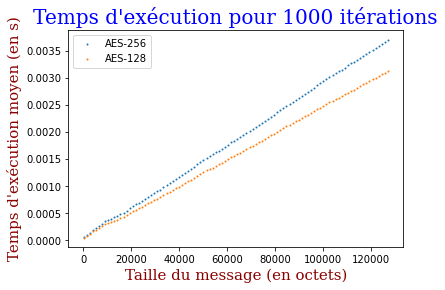

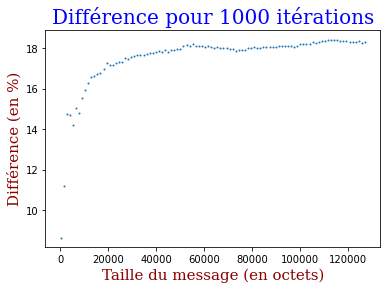

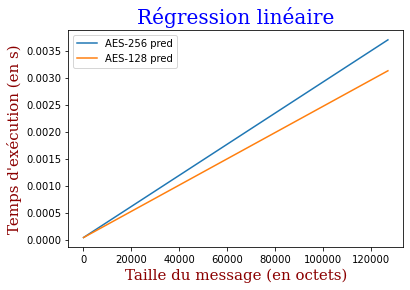

Le coefficient de détermination r² pour AES-256 est de  99.979  %
AES 256 : y = 2.89e-08 x + 3.92e-05

Le coefficient de détermination r² pour AES-128 est de  99.979  %
AES 128 : y = 2.44e-08 x + 3.95e-05

En se basant sur la regression linéaire, on a un pourcentage de différence sur les coefficients de : 18.53


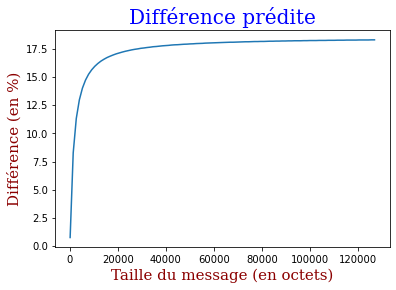



 Temps global :  686.9852151  secondes


In [3]:
start = time.perf_counter()

compare_aes_precise(1, 1000, 10, 100, 10)

end = time.perf_counter()
print("\n\n Temps global : ", end-start, " secondes")

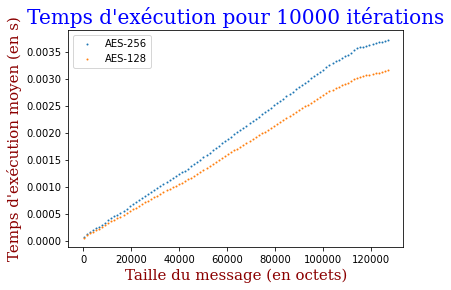

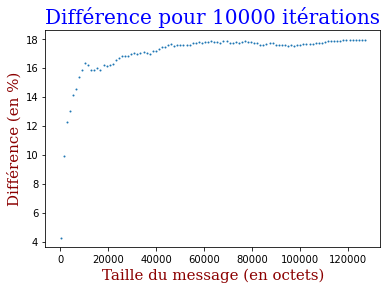

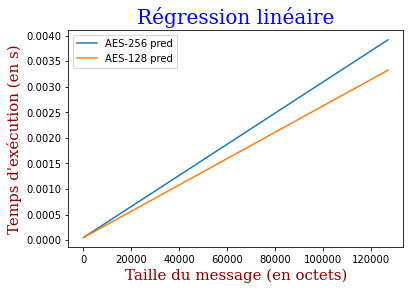

Le coefficient de détermination r² pour AES-256 est de  99.807  %
AES 256 : y = 3.05e-08 x + 4.75e-05

Le coefficient de détermination r² pour AES-128 est de  99.796  %
AES 128 : y = 2.58e-08 x + 4.72e-05

En se basant sur la regression linéaire, on a un pourcentage de différence sur les coefficients de : 18.11


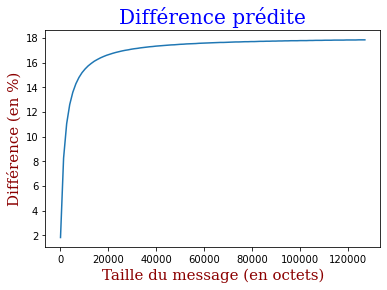



 Temps global :  6874.8570436  secondes


In [4]:
start = time.perf_counter()

compare_aes_precise(1, 1000, 10, 100, 100)

end = time.perf_counter()
print("\n\n Temps global : ", end-start, " secondes")

In [ ]:
# Pour itérer sur une même puissance de 10 on peut utiliser la fonction test_msg :

start = time.perf_counter()

test_msg(5, 1000, 50)

end = time.perf_counter()
print("\n\n Temps global : ", end-start, " secondes")